In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pynq import allocate, Overlay

In [2]:
threshold_design = Overlay("threshold.bit")
for i in threshold_design.ip_dict:
    print(i)

threshold_accel_0
axi_dma_0
processing_system7_0


In [3]:
dma = threshold_design.axi_dma_0
threshold = threshold_design.threshold_accel_0

In [4]:
image_path = "/home/xilinx/jupyter_notebooks/images/gray.png"
original_image = Image.open(image_path)

Image size: 3840x2160 pixels.


<Figure size 864x576 with 0 Axes>

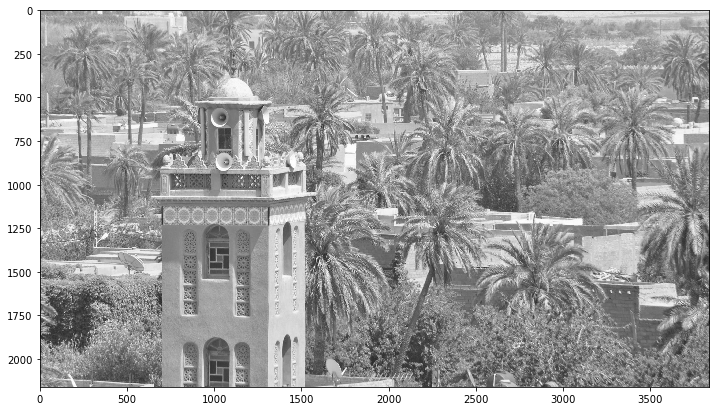

In [5]:
canvas = plt.gcf()
size = canvas.get_size_inches()
canvas.set_size_inches(size*2)
newsize = (3840, 2160)
original_image = original_image.resize(newsize)
width, height = original_image.size
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
#_ = plt.imshow(original_image)
_ = plt.imshow(original_image,cmap='gray', vmin=0, vmax=255)

In [6]:
in_buffer = allocate(shape=(height, width), 
                           dtype=np.uint8, cacheable=1)
out_buffer = allocate(shape=(height, width), 
                           dtype=np.uint8, cacheable=1)

In [7]:
in_buffer[:] = np.array(original_image)

In [8]:
def run_kernel():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)    
    threshold.write(0x00,0x81) # start
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [9]:
threshold.register_map.rows = height
threshold.register_map.cols = width
threshold.register_map.thresh = 110
threshold.register_map.maxval = 255

In [10]:
run_kernel()
threshold_image = Image.fromarray(out_buffer)

Image size: 3840x2160 pixels.


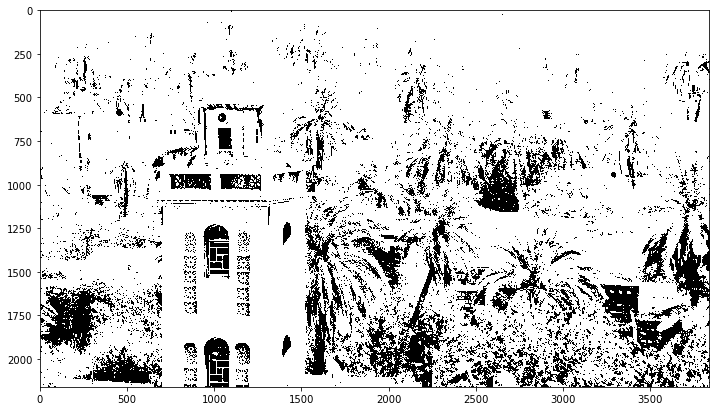

In [11]:
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(threshold_image,cmap='gray', vmin=0, vmax=255)

In [12]:
threshold_image.save('threshold.png')

In [13]:
%%timeit
run_kernel()
threshold_image = Image.fromarray(out_buffer)

117 ms ± 2.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
del in_buffer
del out_buffer

In [18]:
#convert image to greyscale
#original_image=original_image.convert('L') 

In [15]:
threshold = 110
threshold_image_SW = original_image.point(lambda p: p > threshold and 255)

In [16]:
%%timeit
threshold = 110
threshold_image_SW = original_image.point(lambda p: p > threshold and 255)

136 ms ± 388 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Image size: 3840x2160 pixels.


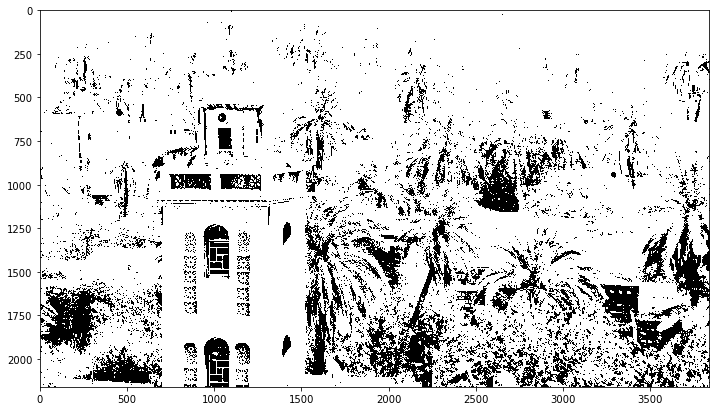

In [17]:
print("Image size: {}x{} pixels.".format(width, height))
plt.figure(figsize=(12, 10));
_ = plt.imshow(threshold_image_SW,cmap='gray', vmin=0, vmax=255)